<a href="https://colab.research.google.com/github/naomiehl/NNHedge/blob/main/TransactionCosts_1_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]

clearall()

In [2]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 5.2 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=1c5cfce14a356e6c3344d7aba018a120209bb22c96dd693bb736fe84e5984950
  Stored in directory: /root/.cache/pip/wheels/2d/25/50/bc80b93c9a827ed9bef9d86f85365e1934bcbc0666b9f00c11
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24468 sha256=0da58d2dfc9c2415265b3898d0676c869582da437fd8fab8a8a4bde931dbc135
  Stored in directory: /root/.cache/pip/wheels/1a/70/10/bf54a16badc528594c9510ef517badb765a29b651ea5652898
Successfully built py-vollib py-lets-be-rational


In [3]:
import time
import sys
import os
from py_vollib.black_scholes.implied_volatility import implied_volatility as implVola
from scipy.stats import norm
import numpy as np, tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class NeuralNetwork(tf.keras.Model):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.LAYERLENGTH = 64
        self.NUMHIDDENLAYERS = 5
        self.l = [tf.keras.layers.Dense(self.LAYERLENGTH,
                                        activation = tf.nn.leaky_relu,
                                        bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True) for i in range(self.NUMHIDDENLAYERS)]

        self.l += [tf.keras.layers.Dense(self.LAYERLENGTH,
                                         activation=tf.nn.tanh,
                                         bias_initializer=tf.zeros_initializer(),
                                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                         use_bias=True)]

        self.l += [tf.keras.layers.Dense(1, activation=tf.nn.tanh, use_bias=True,
                                         bias_initializer=tf.zeros_initializer(),
                                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05))]

    def call(self, x):
        for layer in self.l:
            x = layer(x)
        return x

In [5]:
# Black & Scholes engine

class BlackScholesEngine():
    def callPriceBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        return S*norm.cdf(d1)-norm.cdf(d2)*K*np.exp(-r*T)

    def putPriceBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        return -S*norm.cdf(-d1)+norm.cdf(-d2)*K*np.exp(-r*T)

    def callDeltaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.cdf(d1)

    def putDeltaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return -norm.cdf(-d1)

    def gammaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.pdf(d1)/(S*sigma*np.sqrt(T))

    def vegaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return S*np.sqrt(T)*norm.pdf(d1)



dist_norm =  tfp.distributions.Normal(loc=0., scale=1.)

def callDeltaBlackScholes(t, x, strike, vola, mat): 
    d1 = tf.math.log(x/strike) + 0.5*tf.square(vola)*(mat-t)
    d1 = d1/(vola*tf.cast(tf.math.sqrt(mat-t), tf.float32))
    return dist_norm.cdf(d1)

def putDeltaBlackScholes(t, x, strike, vola, mat): 
    d1 = tf.math.log(x/strike) + 0.5*tf.square(vola)*(mat-t)
    d1 = d1/(vola*tf.cast(tf.math.sqrt(mat-t), tf.float32))
    return -dist_norm.cdf(-d1)

In [6]:
# Spot
S = 20000
# Volatility
vol = 0.6

# Strike of the Call option
K = 20000
# Horizon
T = 0.1
# Number of time steps
nbSteps = 100

# Risk-free rate
r = 0.02
# Implied volatility
sigma = 0.6
# transaction costs
# omega = 0.003
omega = 0.03

class DeepHedgingEngine(tf.keras.Model):
    def __init__(self, r, sigma, omega, vol, S, K, T, nbSteps):
        super(DeepHedgingEngine, self).__init__()

        self.r = r
        self.sigma = sigma
        self.omega = omega
        self.vol = vol
        self.S = S
        self.K = K

        self.T = T
        self.nbSteps = nbSteps
        self.dt = self.T/self.nbSteps
        self.taux = np.linspace(0, self.T, self.nbSteps+1)

        self.priceBS = BlackScholesEngine().callPriceBlackScholes(self.S, self.K, self.T, 0.0, self.sigma)

        self.nn = [NeuralNetwork() for _ in range(self.nbSteps+1)]

    def call(self, n_paths):
        helperX = tf.reshape(0.0, [1,-1])
        X = tf.tile(helperX, [n_paths,1])
        helperDelta = tf.reshape(0.0, [1,-1])
        delta = tf.tile(helperDelta, [n_paths,1])

        helperStochInt = tf.reshape(0.0, [1,-1])
        stochInt = tf.tile(helperStochInt, [n_paths,1])

        for step in np.arange(self.nbSteps):
            G = tf.random.normal(tf.shape(X), mean=0, stddev=1)
            deltaX = - 0.5*self.vol**2*self.dt + self.vol*np.sqrt(self.dt)*G

            inputs = tf.concat((X,delta), axis=1)

            transactionCosts = self.omega*tf.abs(self.hedgingFunction(step, inputs) - delta)*self.S*tf.exp(X)
            delta = self.hedgingFunction(step, inputs)
            stochInt = stochInt + delta*self.S*(tf.exp(X+deltaX)-tf.exp(X))

            X += deltaX

        payoff = tf.maximum(self.S*tf.exp(X)-K, 0)
        hedgingError = self.priceBS + stochInt - payoff - transactionCosts
        return tf.reduce_mean(tf.square(hedgingError)), hedgingError

    def hedgingFunction(self, mat_index, inputs):
        return self.nn[mat_index](inputs)

In [7]:
model = DeepHedgingEngine(r, sigma, omega, vol, S, K, T, nbSteps)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function(
input_signature=[
    tf.TensorSpec(shape=None, dtype=tf.int32),
],
)
def train_step(n_paths):
    with tf.GradientTape() as tape:
        loss_value = model(n_paths)[0]
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

first_time = model(1)
first_time

(<tf.Tensor: shape=(), dtype=float32, numpy=630998.7>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[794.35425]], dtype=float32)>)

In [8]:
batch_size = tf.constant(256)
maxIter = 10000

start_time = time.time()

for k in range(maxIter):
    loss_value = train_step(batch_size)

print("--- loss function: ", np.round(loss_value.numpy(), 6), "    ---")
print("---", time.time() - start_time, "seconds ---")

--- loss function:  25291.09     ---
--- 2111.0399599075317 seconds ---


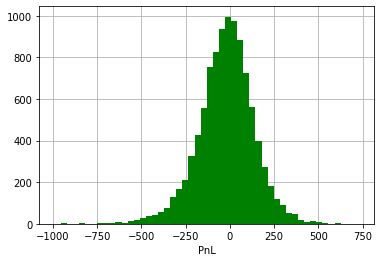

In [9]:
nbSim = 10000
PnL = model(nbSim)[1].numpy()

plt.hist(PnL, 50, facecolor='g', zorder=3)
plt.xlabel("PnL")
plt.grid(zorder=1)
plt.show()

In [12]:
print("mean",PnL.mean())
print("std",PnL.std())
print("percentile 5",np.percentile(PnL, 5))
print("percentile 95",np.percentile(PnL, 95))
VaR_95 = norm.ppf(0.95, loc = PnL.mean(), scale = PnL.std())
print("Var_95", VaR_95)

tail_loss = norm.expect(lambda x: x, loc = PnL.mean(), scale = PnL.std(), lb = VaR_95)
CVaR_95 = (1 / (1 - 0.95)) * tail_loss
print("CVar_95", CVaR_95)


from scipy.stats import norm
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05
cutoff1 = norm.ppf(conf_level1, PnL.mean(), PnL.std())
var_1d1 = S - cutoff1
print("vatR",cutoff1)

mean -22.779272
std 158.46344
percentile 5 -286.72279357910156
percentile 95 220.4592750549316
Var_95 237.8698918473611
CVar_95 304.0852950093408
vatR -283.42843600629675


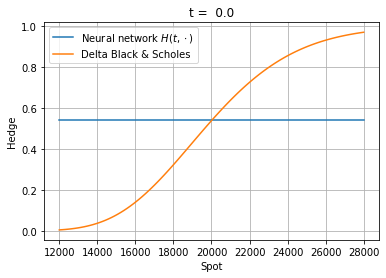

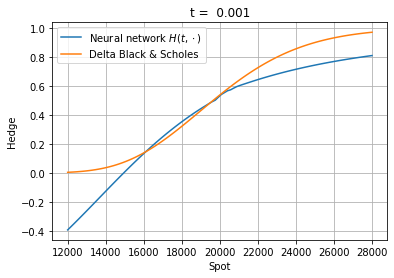

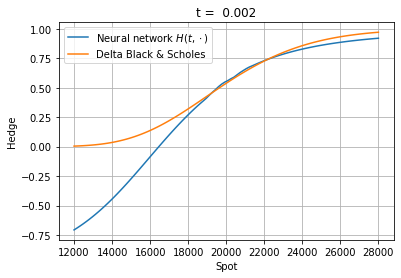

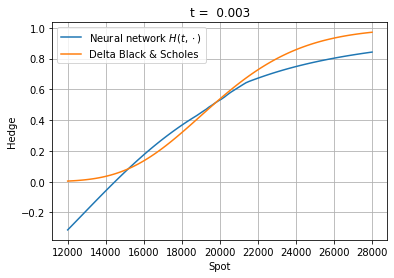

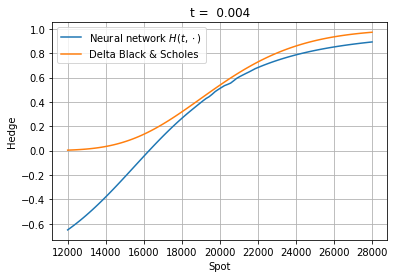

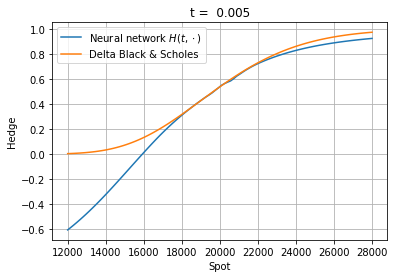

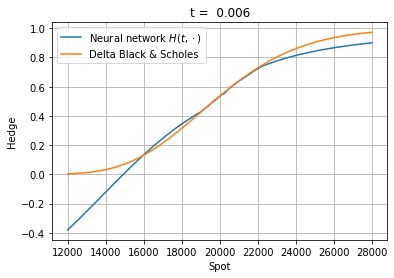

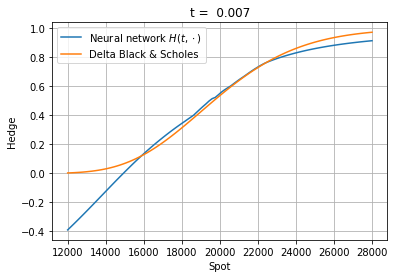

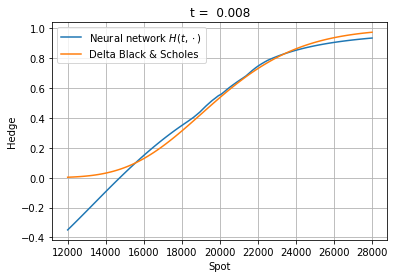

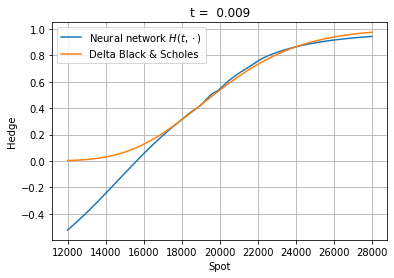

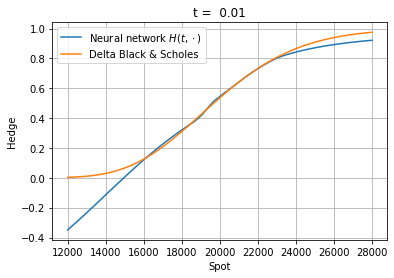

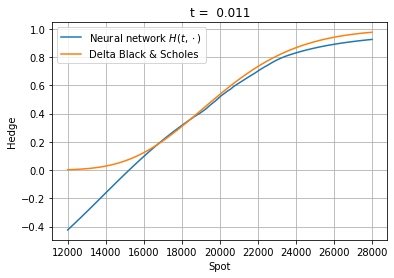

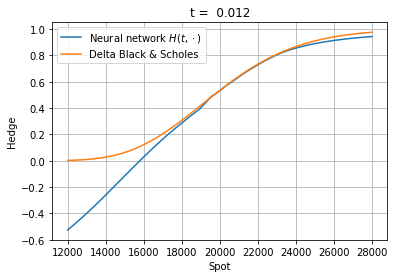

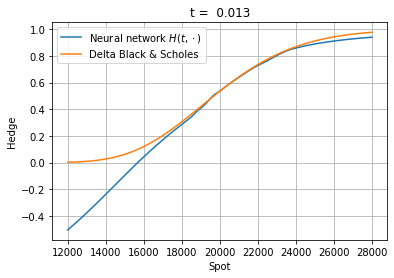

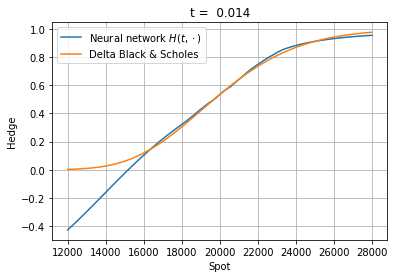

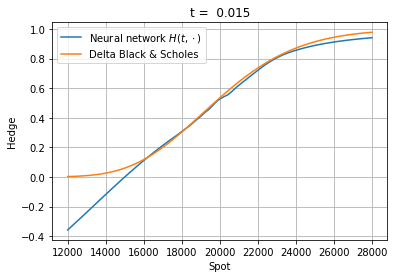

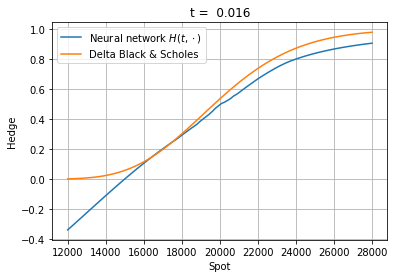

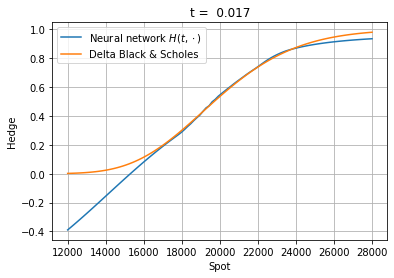

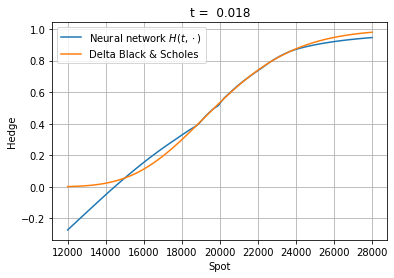

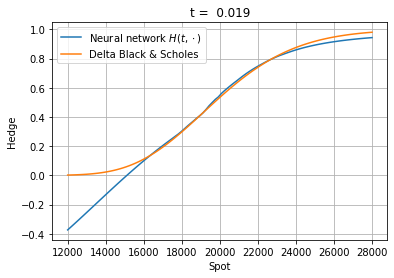

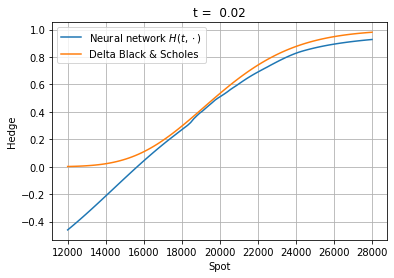

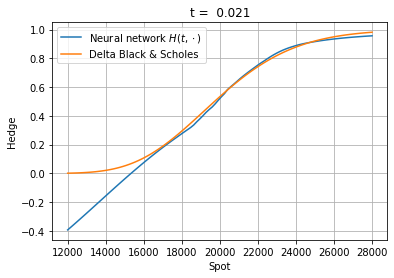

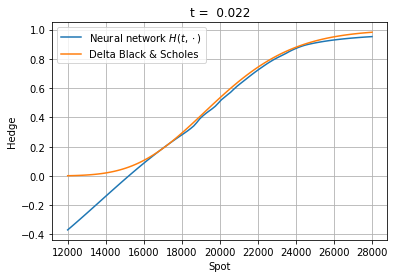

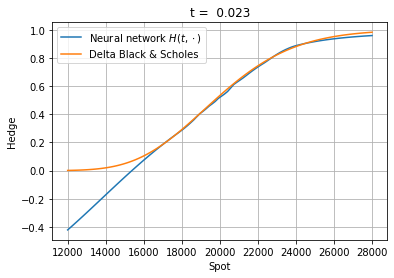

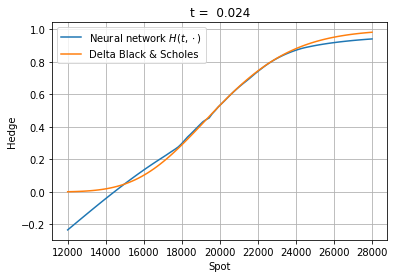

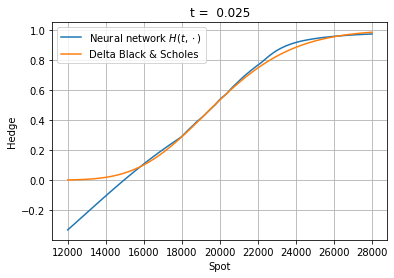

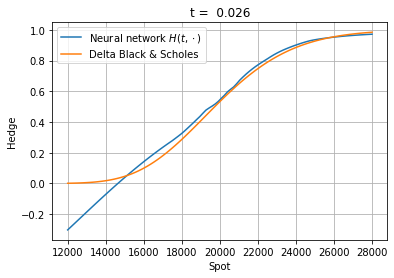

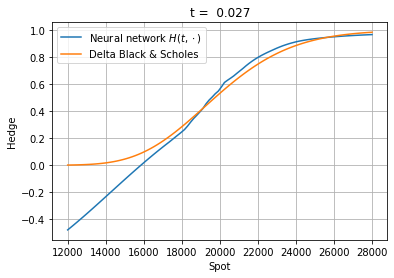

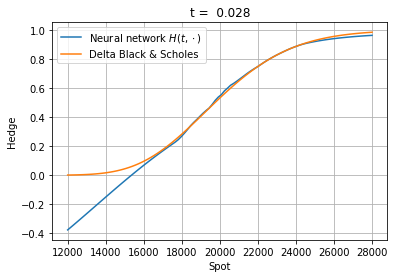

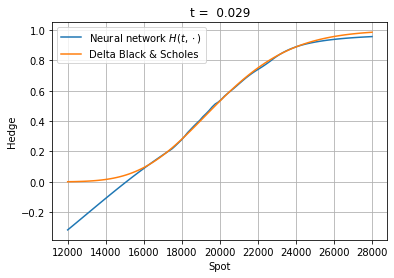

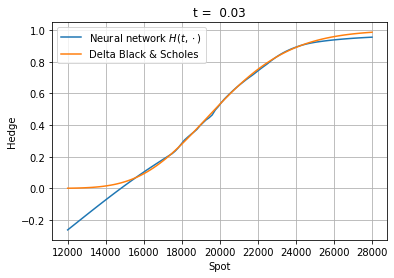

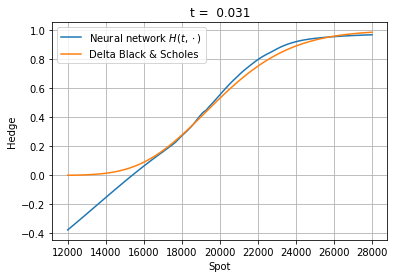

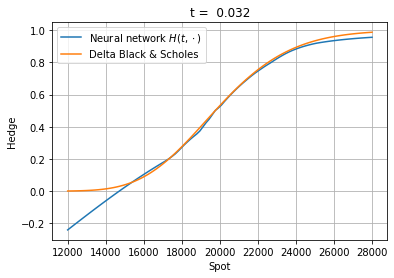

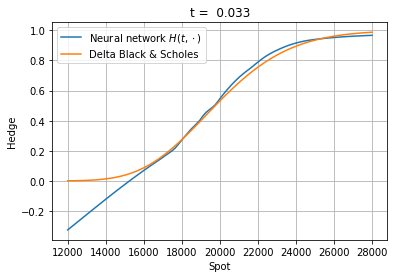

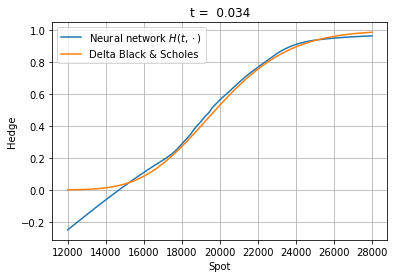

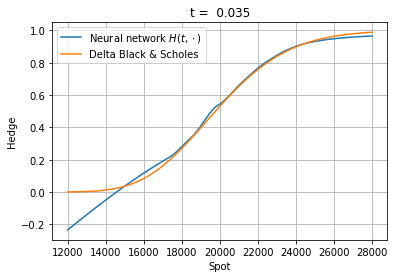

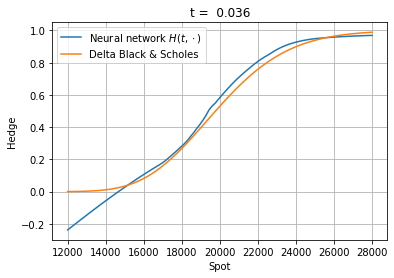

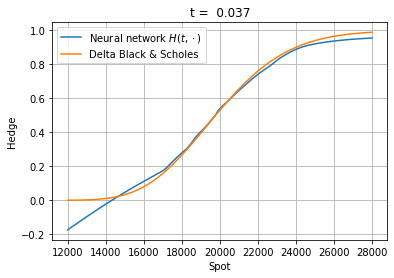

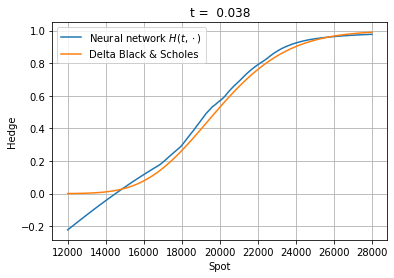

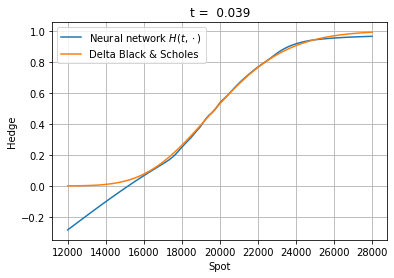

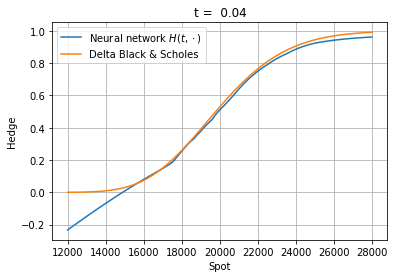

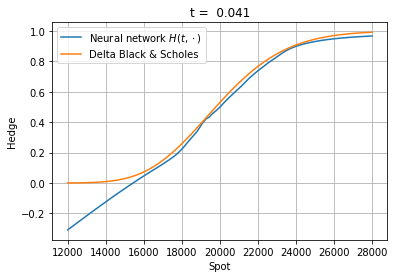

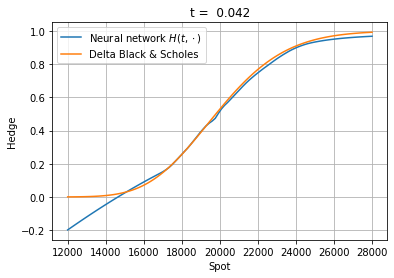

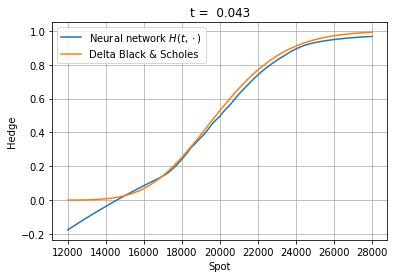

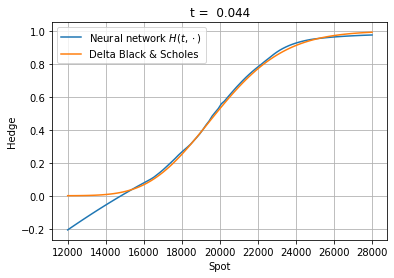

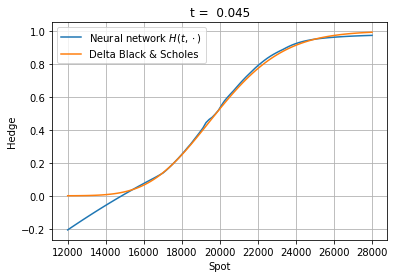

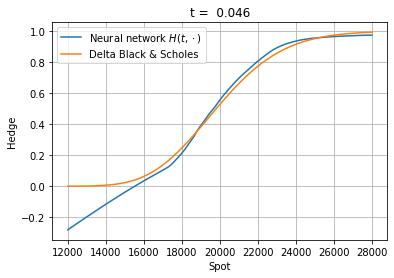

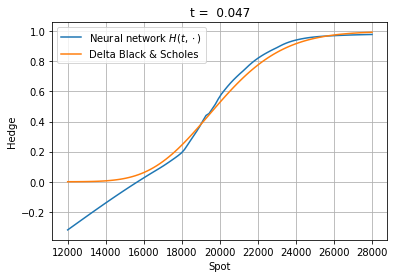

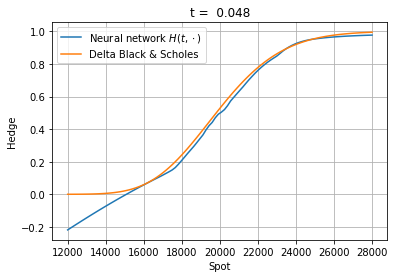

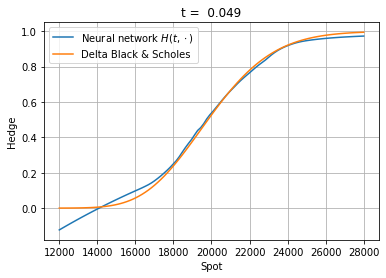

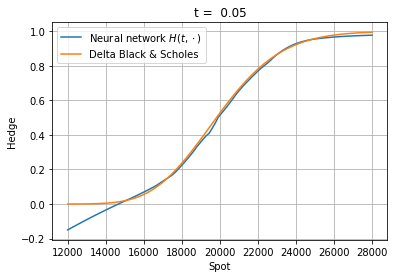

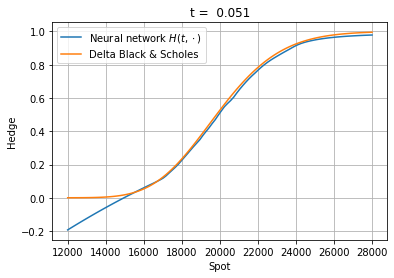

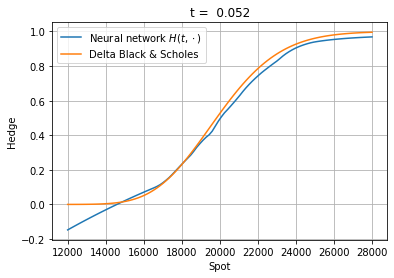

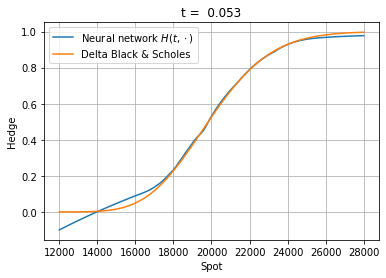

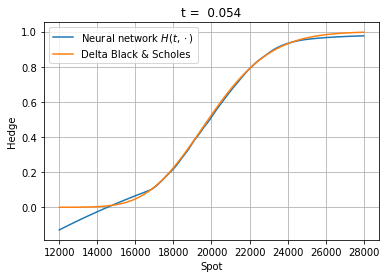

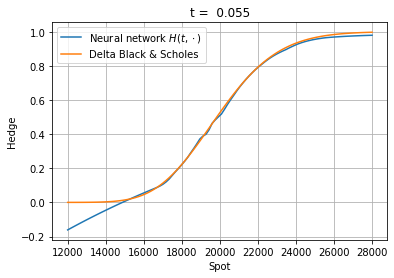

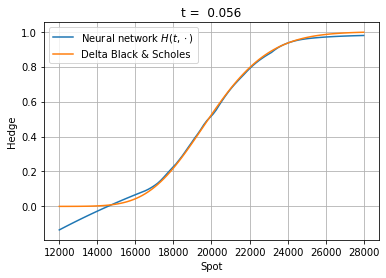

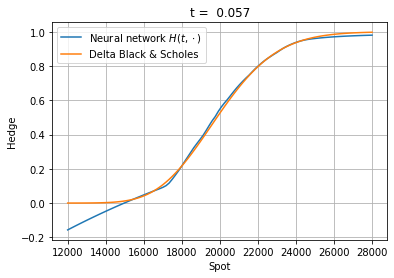

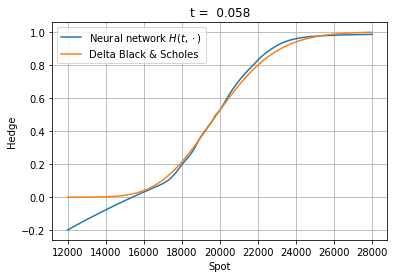

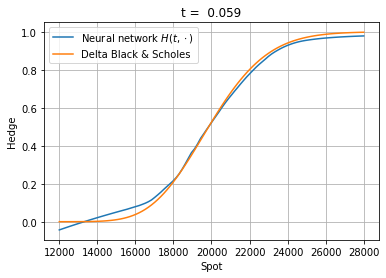

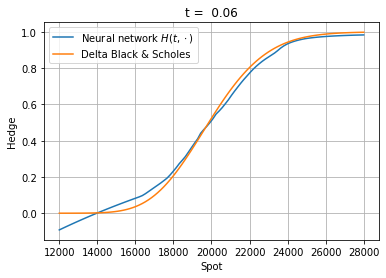

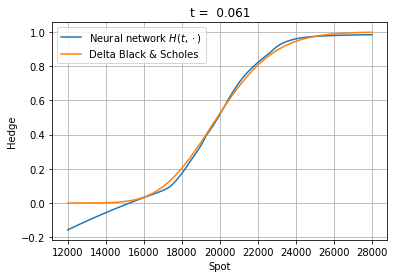

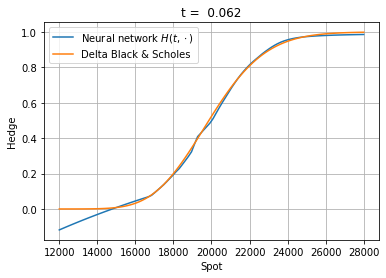

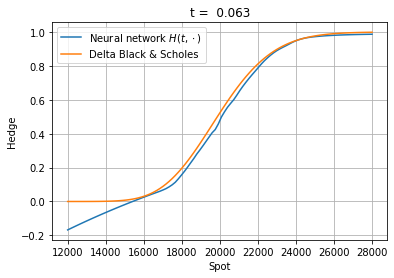

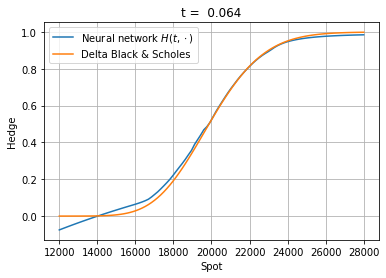

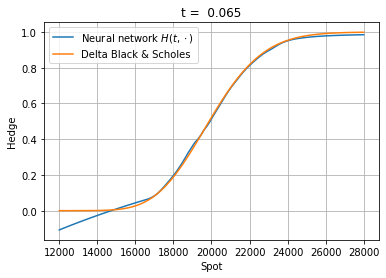

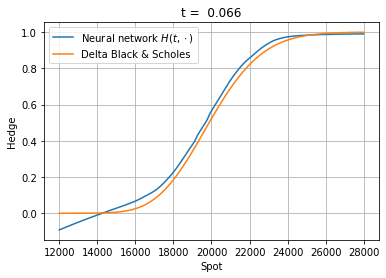

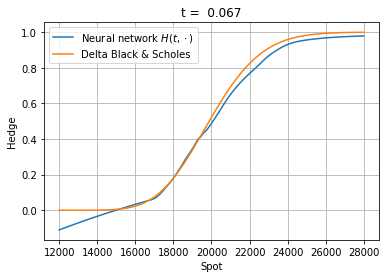

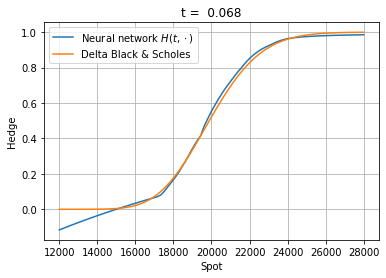

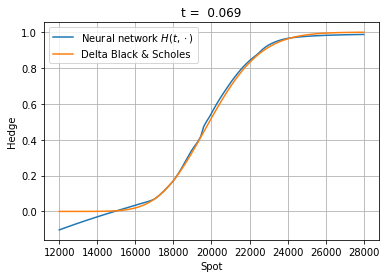

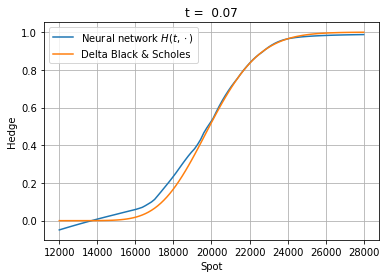

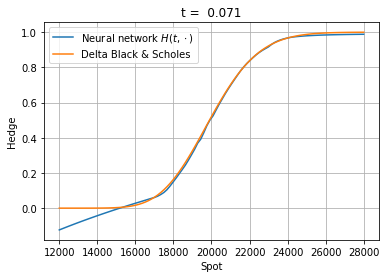

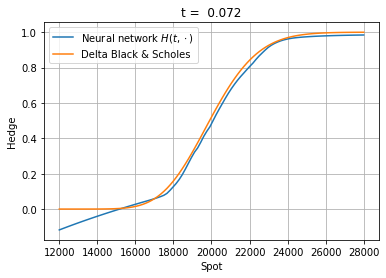

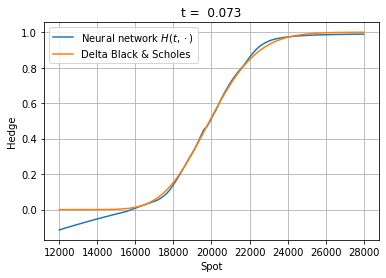

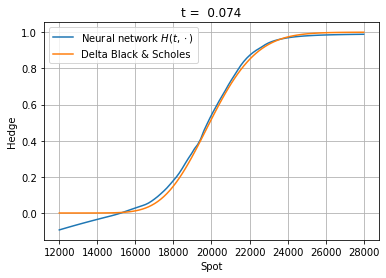

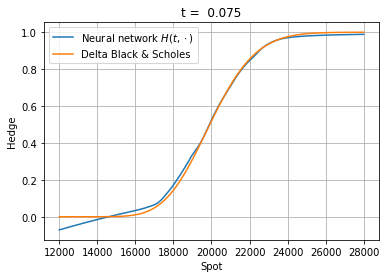

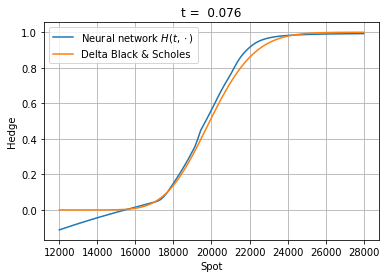

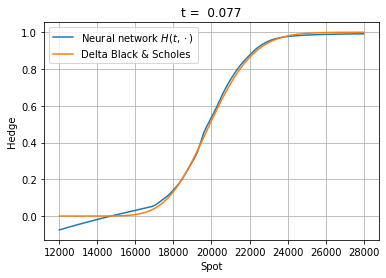

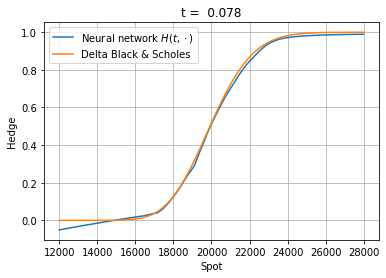

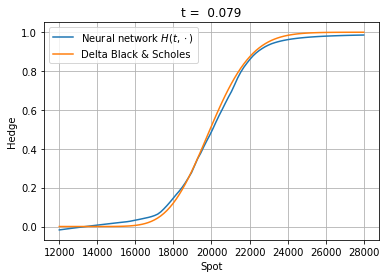

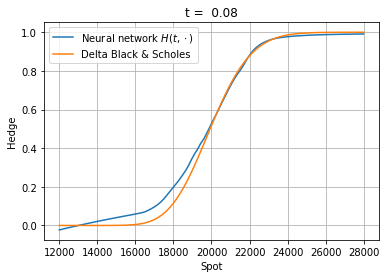

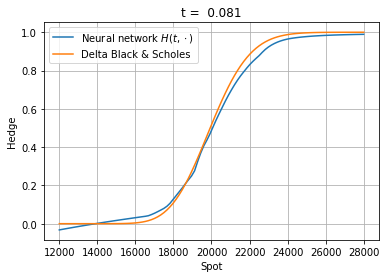

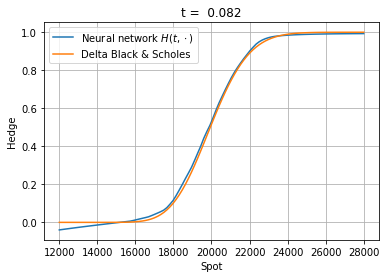

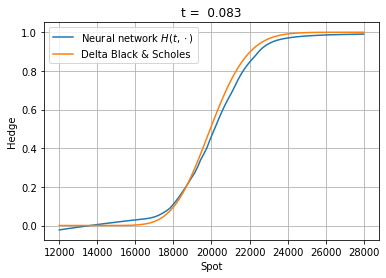

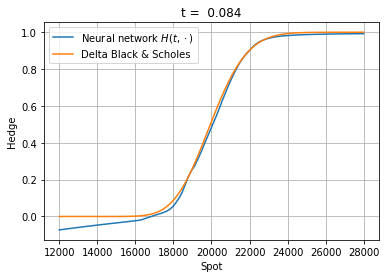

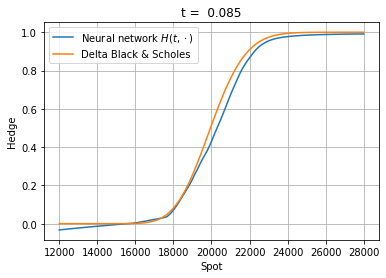

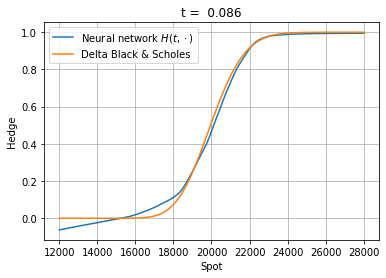

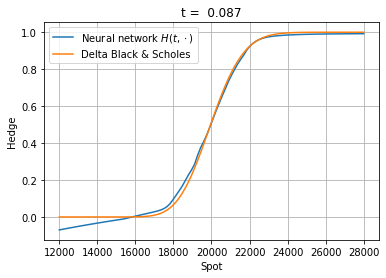

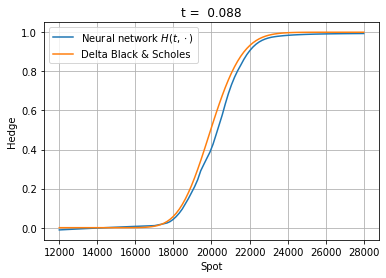

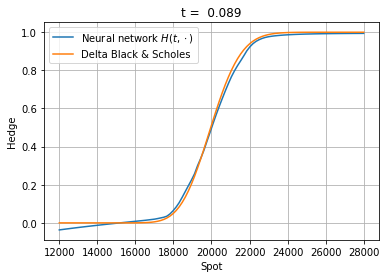

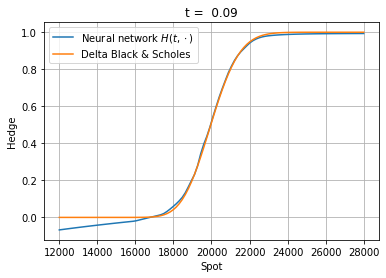

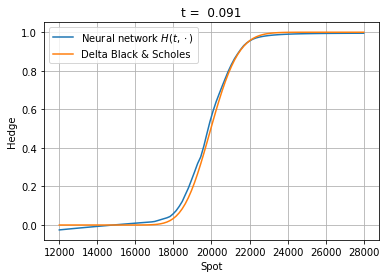

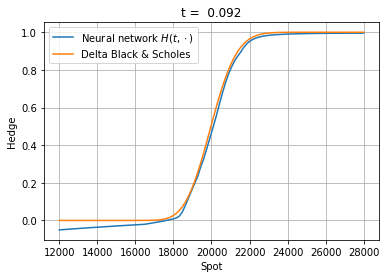

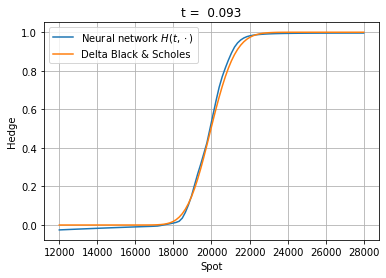

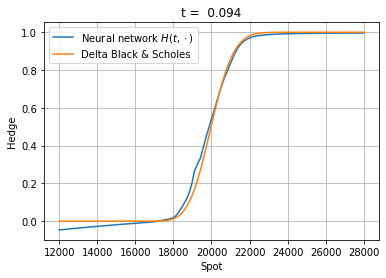

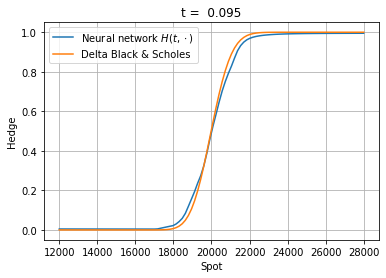

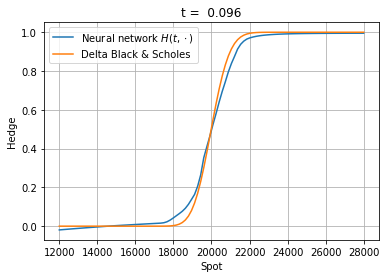

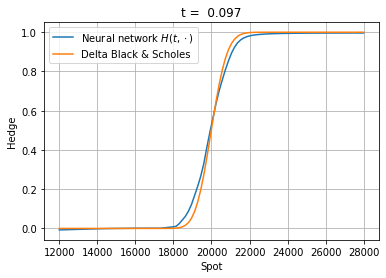

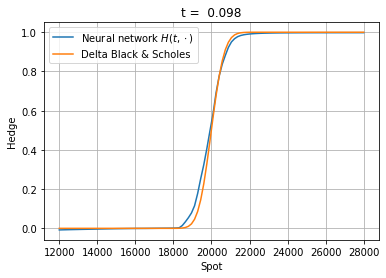

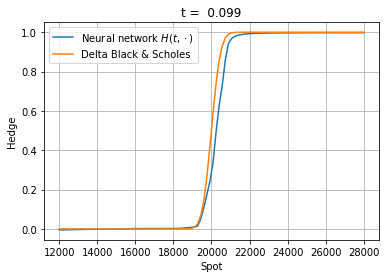

In [11]:
size = 100

arraySpot = np.linspace(0.6*model.S, 1.4*model.S, size)
arraySpot = arraySpot.astype(np.float32)
arraySpot = np.reshape(arraySpot, [-1,1])

arrayDelta = np.zeros(size)
arrayDelta = arrayDelta.astype(np.float32)
arrayDelta = np.reshape(arrayDelta, [-1,1])

for i in range(model.nbSteps):
    plt.plot(arraySpot, model.hedgingFunction(i, np.concatenate((np.log(arraySpot/model.S),arrayDelta),axis=1)), label="Neural network $H(t, \cdot)$")
    plt.plot(arraySpot, BlackScholesEngine().callDeltaBlackScholes(arraySpot, model.K, model.T-model.taux[i], 0.0, model.sigma), label="Delta Black & Scholes")
    plt.title("t =  {}".format(np.round(model.taux[i], 4)))
    arrayDelta = model.hedgingFunction(i, np.concatenate((np.log(arraySpot/model.S),arrayDelta),axis=1))
    plt.xlabel("Spot")
    plt.ylabel("Hedge")
    plt.legend()
    plt.grid()
    plt.show()